In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Farmland & Crops Keras EfficientNet

## Import Package


In [46]:
import os
import time
import datetime
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [47]:
# %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [48]:
SEED = 5397
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.set_soft_device_placement(True)

In [49]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # Show GPU information
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

Not connected to a TPU runtime. Using CPU/GPU strategy
Found GPU at: /device:GPU:0
Sun Sep 25 15:34:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.59       Driver Version: 512.59       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P8    13W / 160W |    647MiB /  6144MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
     

## Const & Inputs

Here are all of the parameters to change for the run.


In [50]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
# path = "/content/drive/MyDrive/Colab Notebooks/aidea-farmland-crops-autumn"
path = "."

# Folder of the training data
training_folder = 'train'

# Folder of the testing data
testing_folder = 'test'

# Number of classes in the dataset
num_classes = 33

# Image size for model
image_size = 224

# Get the shape of the input layer
input_shape = (image_size, image_size, 3)

## Helper Functions

Before we write the code for adjusting the models, lets define a few helper functions.


In [67]:
!pip install -U scikit-learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def evaluate(y_true, y_pred,zero_division = 1):
    labels = sorted(list(set(y_true + y_pred)))
    eval_result = classification_report(
        y_true, y_pred, target_names=labels, 
        output_dict=True, zero_division=zero_division
    )['weighted avg']
    return eval_result

In [7]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.application import MIMEApplication

def send_mail(receiver, title, message):
    content = MIMEMultipart()
    content["subject"] = f"{title}"
    content["from"] = "siang07734@gmail.com"
    content["to"] = receiver
    content.attach(MIMEText(message))

    # build SMTP server and send mail
    with smtplib.SMTP(host="smtp.gmail.com", port="587") as smtp:
        try:
            smtp.ehlo()
            smtp.starttls()
            smtp.login("siang07734@gmail.com", "hinruqzmjacjbyzh")
            smtp.send_message(content)
        except Exception as e:
            print("Error message: ", e)

## Data Preprocessing

Include: laod data, encode categorical features, split data, normalize data, and save data.


In [8]:
# Whether to reprocess the data
reprocess = False

# Encoder to choose from [OneHotEncoder, LabelEncoder]
encoder = 'OneHotEncoder'

### Load Data
The training set has been randomly split into train(85%) and valid(15%) in advance.

In [9]:
# fullset = pd.read_csv(f'{path}/data/fullset.csv')
# fullset.groupby('set_name').count()
subset = pd.read_pickle(F'{path}/data/subset.pkl')
subset.groupby('set_name').count()

,file,label,shape,height,width,make,model,taken_datetime,taken_month,taken_year,taken_hour,target_fid,target_x,target_y,county_name,town_name,town_x,town_y
set_name,,,,,,,,,,,,,,,,,,
test,3397,3397,3397,3397,3397,2094,2094,2061,2061,2061,2061,3397,3397,3397,3397,3397,3397,3397
train,15656,15656,15656,15656,15656,9751,9754,9601,9601,9601,9601,15656,15656,15656,15656,15656,15656,15656
valid,3310,3310,3310,3310,3310,2073,2074,2044,2044,2044,2044,3310,3310,3310,3310,3310,3310,3310


In [10]:
# train = fullset[fullset['set_name'].eq('train')].reset_index(drop=True)
# valid = fullset[fullset['set_name'].eq('valid')].reset_index(drop=True)
# test = pd.read_csv(F'{path}/data/describe(test).csv')
# test = pd.DataFrame({'filename': [f for f in os.listdir(f'{path}/data/{testing_folder}') if os.path.isfile(os.path.join(f'{path}/data/{testing_folder}', f))]})
# train = subset[subset['set_name'].eq('train')].reset_index(drop=True)
# valid = subset[subset['set_name'].eq('valid')].reset_index(drop=True)
# test = subset[subset['set_name'].eq('test')].reset_index(drop=True)
# print(F"train: {train.shape}, valid: {valid.shape}, test: {test.shape}")

We can choose to process the data from scratch, or read data that has already been processed.

In [11]:
if(reprocess):
    tqdm.pandas()
    train["vector"] = train.progress_apply(lambda row: load_image_and_resize(F'D:/Dataset/aidea-farmland-crops-autumn/train/{row["label"]}/{row["file"]}', new_size=224, resize_method="resize"), axis=1)
    pd.to_pickle(train, F'{path}/data/subset_train_vector_224.pkl', protocol=4)
    tqdm.pandas()
    valid["vector"] = valid.progress_apply(lambda row: load_image_and_resize(F'D:/Dataset/aidea-farmland-crops-autumn/train/{row["label"]}/{row["file"]}', new_size=224, resize_method="resize"), axis=1)
    pd.to_pickle(valid, F'{path}/data/subset_valid_vector_224.pkl', protocol=4)
    tqdm.pandas()
    test["vector"] = test.progress_apply(lambda row: load_image_and_resize(F'D:/Dataset/aidea-farmland-crops-autumn/train/{row["label"]}/{row["file"]}', new_size=224, resize_method="resize"), axis=1)
    pd.to_pickle(test, F'{path}/data/subset_test_vector_224.pkl', protocol=4)
else:
    train = pd.read_pickle(F'{path}/data/subset_train_vector_224.pkl')
    valid = pd.read_pickle(F'{path}/data/subset_valid_vector_224.pkl')
    test = pd.read_pickle(F'{path}/data/subset_test_vector_224.pkl')

### Encode categorical features

OneHotEncoder or LabelEncoder.


In [12]:
if(encoder == 'OneHotEncoder'):
    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(subset['label'].values.reshape(-1, 1))
    train['class'] = list(np.array(enc.transform(train['label'].values.reshape(-1, 1)).toarray().tolist()))
    valid['class'] = list(np.array(enc.transform(valid['label'].values.reshape(-1, 1)).toarray().tolist()))
    test['class'] = list(np.array(enc.transform(test['label'].values.reshape(-1, 1)).toarray().tolist()))
elif(encoder == 'LabelEncoder'):
    from sklearn.preprocessing import LabelEncoder
    enc = LabelEncoder()
    enc.fit(subset['category'].values)
    train['class'] = np.array(enc.transform(train['label'].values))
    valid['class'] = np.array(enc.transform(valid['label'].values))
    test['class'] = np.array(enc.transform(test['label'].values))

## Model Helper

In [13]:
from sklearn.utils import class_weight
sample_weight = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=list(train['class'].values)
)

In [14]:
def get_reducelr():
    return tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=np.sqrt(0.1),
        patience=10,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0.5e-7,
    )

In [ ]:
def get_tensorboard(path):
    return tf.keras.callbacks.TensorBoard(log_dir=path)

In [ ]:
def get_checkpoint(model_name, monitor):
    return tf.keras.callbacks.ModelCheckpoint(
        model_name,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        save_freq='epoch'
    )

In [ ]:
def get_early_stop(patience):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0,
        patience=patience,
        restore_best_weights=True
    )

In [ ]:
class NotifyCallBack(tf.keras.callbacks.Callback):
    def __init__(self, monitor='', mode='max', patience=5, title=''):
        self.monitor = monitor
        self.mode = mode
        self.patience = patience
        self.title = title
        
    def on_train_begin(self, logs = None):
        self.history = [] #Initializing the list of losses

    def on_epoch_begin(self, epoch, logs = None):
        pass

    def on_epoch_end(self, epoch, logs = None):
        self.history.append(logs)
        if(epoch%self.patience==0):
            history = pd.DataFrame(self.history)
            if(self.mode=='max'):
                message = f"Currently executed to {epoch}'s EPOCH, the `{self.monitor}` of model is {history[self.monitor].max()}."
            else:
                message = f"Currently executed to {epoch}'s EPOCH, the `{self.monitor}` of model is {history[self.monitor].min()}."
            send_mail("siang07734@gmail.com", self.title, message)
            
    def on_train_end(self, logs = None):
        send_mail("siang07734@gmail.com", self.title, "The training has ended")

def get_notify(monitor, title):
    return NotifyCallBack(monitor, 'max', 5, title)

## EfficientNet modelling + training

Using EfficientNetB0~B7.


### Initialize and Reshape the Networks


In [15]:
def get_augmentation():
    augmentation = tf.keras.models.Sequential()
    augmentation.add(tf.keras.layers.RandomContrast(factor=0.15))
    augmentation.add(tf.keras.layers.RandomFlip('horizontal_and_vertical'))
    augmentation.add(tf.keras.layers.RandomZoom(0.15, 0.15))
    augmentation.add(tf.keras.layers.RandomTranslation(height_factor=0.15, width_factor=0.15))
    augmentation.add(tf.keras.layers.RandomRotation(factor=0.15))
    return augmentation

In [16]:
def get_model(input_shape, num_classes, learning_rate=5e-04, dropout=0.2, isAugmentationActivated=False):
    model = tf.keras.models.Sequential()
    if(isAugmentationActivated):
      model.add(get_augmentation())
    model.add(tf.keras.applications.EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet', drop_connect_rate=dropout))
    model.add(tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"))
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_initializer=tf.keras.initializers.he_uniform(seed=5397), name="pred"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'], run_eagerly=False)
    return model  

In [17]:
def get_batch_dataset(train_vector, train_class, valid_vector, valid_class, batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices((train_vector, train_class)).shuffle(10000, seed=5397).batch(batch_size, drop_remainder=True)
    valid_ds = tf.data.Dataset.from_tensor_slices((valid_vector, valid_class)).batch(batch_size, drop_remainder=True)
    return train_ds, valid_ds
def data_generator(dataframe):
    # iter dataframe
    for i, row in dataframe.iterrows():   
        yield (np.array(row['vector'].tolist())), np.array(row['class'].tolist())
def get_batch_dataset_from_generator(train, valid, input_shape, num_classes, batch_size):
    train_ds = tf.data.Dataset.from_generator(lambda: data_generator(train.sample(frac=1).reset_index(drop=True)), 
        output_types=(tf.uint8, tf.float64), 
        output_shapes=([input_shape[0], input_shape[1], input_shape[2]], [num_classes])).batch(batch_size, drop_remainder=True)
    valid_ds = tf.data.Dataset.from_generator(lambda: data_generator(valid),
        output_types=(tf.uint8, tf.float64), 
        output_shapes=([input_shape[0], input_shape[1], input_shape[2]], [num_classes])).batch(batch_size, drop_remainder=True)
    return train_ds, valid_ds

### Visualize data augmentation 

### Modelling


In [18]:
# [10, 30, 50, 100, 150]
EPOCHS = 100

# [16, 32(default), 64, 128, 256, 512, 1024]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# learning rate
LR_START = 5e-04

DROPOUT = 0.0

# Define model name
model_name = F'subset_{input_shape[0]}_efficientnetb5_transfer_trainable_epochs{EPOCHS}_batchsize{BATCH_SIZE}_lr{LR_START}_reducelr_dropout{int(DROPOUT*100)}_sampleweight'
# model_name = f'efficientnetb5(transfer,trainable,datagen-all-15,tpu,simple)-epochs{EPOCHS}-batchsize{BATCH_SIZE}-lr{LR_START}-reducelr-DROPOUT{int(DROPOUT*100)}-{input_shape[0]}'

In [29]:
# Dataset to train
train_vector, train_class = np.array(train['vector'].tolist()), np.array(train['class'].tolist()) 
valid_vector, valid_class = np.array(valid['vector'].tolist()), np.array(valid['class'].tolist()) 
train_ds, valid_ds = get_batch_dataset(train_vector, train_class, valid_vector, valid_class, BATCH_SIZE)

In [26]:
with strategy.scope():    
    model = get_model(input_shape, num_classes, LR_START, DROPOUT, isAugmentationActivated=False)

In [ ]:
start = time.time()

# Train model
history = model.fit(
  train_ds,
  epochs=EPOCHS,
  validation_data=valid_ds,
  verbose=2,
  # sample_weight=sample_weight,
  callbacks=[
    get_checkpoint(F'{path}/models/{model_name}.h5', 'val_categorical_accuracy'), 
    # get_tensorboard(F'{path}/tensorboard/{model_name}'),
    get_early_stop(50),
    get_reducelr(),
    get_notify(monitor='val_categorical_accuracy', title=model_name)
  ],
)

# Save history
pd.DataFrame(history.history).to_csv(f'{path}/logs/{model_name}.csv', index=False)

end = time.time()
print(format(end-start))
# get_batch_dataset_from_generator(test, valid), B0, GPU: 900s
# get_batch_dataset(test, valid), B5, GPU: 600s
# get_batch_dataset(test, valid), B0, GPU: 96s (第 2 次 6s)


epochs:  52


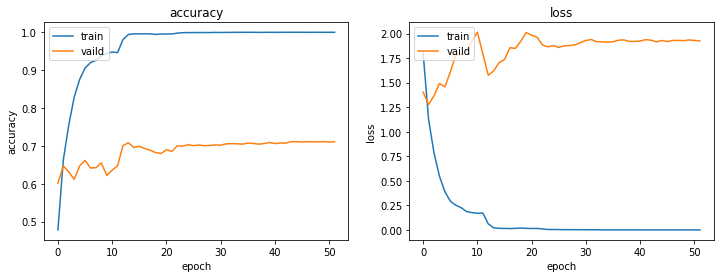

In [59]:
b6log = pd.read_csv(F'{path}/logs/{model_name}.csv')
print('epochs: ',len(b6log))
plt.figure(figsize=(12, 4))

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(b6log['categorical_accuracy'])
plt.plot(b6log['val_categorical_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 

# Summarize history for loss 
plt.subplot(1, 2, 2)
plt.plot(b6log['loss']) 
plt.plot(b6log['val_loss']) 
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 
# plt.show()
# save image
plt.savefig(F'{path}/logs/{model_name}.jpg')

### Prediction of vaild
Prediction based on the best model during training

In [95]:
def predict_and_evaluate(model, data_vector, data_class, encoder):
    pred_class = model.predict(data_vector, verbose=1)
    # Transform the encoded predictions to their actual values
    pred_class_inverse = enc.inverse_transform(pred_class).reshape(-1)
    true_class_inverse = enc.inverse_transform(data_class).reshape(-1)
    # Evaluate the model
    evaluation = evaluate(true_class_inverse.tolist(), pred_class_inverse.tolist())
    return evaluation

In [64]:
# Dataset to valid
test_vector, test_class = np.array(test['vector'].tolist()), np.array(test['class'].tolist())

In [60]:
# Load model with the best validation accuracy
with strategy.scope():    
    model = get_model(input_shape, num_classes)
    model.load_weights(f'{path}/models/{model_name}.h5')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [92]:
# Predict the response for valid dataset
train_evaluation = predict_and_evaluate(model, train_vector, train_class, enc)
train_evaluation = {F'train.{key}': value for key, value in train_evaluation.items()}
valid_evaluation = predict_and_evaluate(model, valid_vector, valid_class, enc)
valid_evaluation = {F'valid.{key}': value for key, value in valid_evaluation.items()}
test_evaluation = predict_and_evaluate(model, test_vector, test_class, enc)
test_evaluation = {F'test.{key}': value for key, value in test_evaluation.items()}
evaluation = pd.DataFrame([{'experiment': model_name, **train_evaluation, **valid_evaluation, **test_evaluation}])
evaluation

{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 3397}

In [88]:
evaluations = pd.read_csv(F'{path}/evaluations.csv')
evaluations = evaluations.append(evaluation)
evaluations.to_csv(F'{path}/evaluations.csv', index=False)

,experiment,precision,recall,f1-score,support
0,subset_224_efficientnetb0_transfer_trainable_e...,1.0,1.0,1.0,3397
0,subset_224_efficientnetb0_transfer_trainable_e...,1.0,1.0,1.0,3397
